### Too many features
In our dataset we have **36 features** and one **target** field (dropout or not). 36 features looks like a high number of characteristics for such a simple problem as the current one. Probably, we'll need to reduce them.

For that purpose let's build and train a backpropagation model (i.e. minimize the loss as minimum as possible). Once we have the trained model we can **rank the features by their importance** (weights). This way we can identify the few **key features**, that has biggest impact on the **target** value.

In [1]:
from csv import reader
import numpy as np
import matplotlib.pyplot as plt

# Set the float formatter for numpy arrays
float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

Let's load the data first.

In [2]:
data = list()
with open('data/students_dataset.csv', 'r') as file:
    csv_reader = reader(file)
    for row in csv_reader:
        data.append(row)

# Remember the feature names
feature_names = data[0][:-1]

# Then remove them from the dataset
data = data[1:]

### Encode the categorical data
We need to encode the text columns and convert them into numbers. In our case we have a single column to encode.

In [3]:
# Loop through the data and encode the target column (0 - Dropout, 1 - Graduate, 2 - Enrolled)
for row in data[0:]:
    row[-1] = 0 if row[-1] == 'Dropout' else 1 if row[-1] == 'Graduate' else 2 # 2 Enrolled

We need also to convert all the values to `float` numbers (basically, the CSV keeps the data in `string` fields).

In [4]:
# Convert all values to float
data = [[float(value) for value in row] for row in data]
len(data)

4423

We would like to throw away the `Enrolled` students, since this is more like a noise in our dataset. The enrolled students are those which haven't passed their exams at the end of the year, but they haven't dropped school. Yet!

Since this cluster of students is close to both the other ones - we would like to remove them from the dataset.

In [5]:
# Filter out the `Enrolled` students (keep only `Dropout` and `Graduate`).
data_filtered = [row for row in data if row[-1] != 2]
len(data_filtered)

3629

Now, it's time to remove the data outliers. It is a good practice to get rid of them before training. 

### IQR

The Interquartile Range, or IQR, is a measure of statistical dispersion. It represents the range within which the middle 50% of the data falls. To calculate the $IQR$, you need to find the difference between the 75th percentile ($Q_3$) and the 25th percentile ($Q_1$).

$$IQR = Q_3 — Q_1$$

To identify outliers using the IQR method, we establish two boundaries:

* Lower Bound: $Q_1 – k * IQR$
* Upper Bound: $Q_3 + k * IQR$

Where $k$ is a coefficient with value higher than $1$. Usually, a low number is being used - between $1.5$ and $2$. But it depends on the data dispersion for the specific feature.


<center><img src="img/iqr.png" alt="IQR" width="801" height="392" /></center>
<p style="text-align: center; font-size: small;"><i><b>Figure 27.</b> Interquartile Range and Boxplot</i></p>

These are the non-categorical columns for which we could apply the **IQR rule** are:
 * `GDP`
 * `Inflation`
 * `Unemployment`
 * `Curricular units 2nd sem (without evaluations)`
 * `Curricular units 2nd sem (grade)`
 * `Curricular units 2nd sem (approved)`
 * `Curricular units 2nd sem (evaluations)`
 * `Curricular units 2nd sem (enrolled)`
 * `Curricular units 2nd sem (credited)`
 * `Curricular units 1st sem (without evaluations)`
 * `Curricular units 1st sem (grade)`
 * `Curricular units 1st sem (approved)`
 * `Curricular units 1st sem (evaluations)`
 * `Curricular units 1st sem (enrolled)`
 * `Curricular units 1st sem (credited)`
 * `Age at enrollment`
 * `Admission grade`
 * `Previous qualification (grade)`


In [6]:
# Remove outliers
k = 1.5

for col_idx in [35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,19,12,6]: # We will apply the IQR rule on specific features only.
    # Extract all values for that column in a single list.
    column_values = [row[col_idx] for row in data_filtered]

    # Calculate the first and third percentile
    Q1 = np.percentile(column_values, 25)
    Q3 = np.percentile(column_values, 75)

    # Calculate the range between 25% and 75% of the population
    IQR = Q3 - Q1

    # Increase the range, so we won't lose a lot of data
    lower_bound = Q1 - (k * IQR)
    upper_bound = Q3 + (k * IQR)

    # Return the rows within that range
    data_without_outliers = [row for row in data_filtered if row[col_idx] >= lower_bound and row[col_idx] <= upper_bound]

    # Update the variable before starting the new loop iteration (the dataset gets reduced with each iteration)
    data_filtered = data_without_outliers

len(data_without_outliers)

1437

Before we continue, we need to separate the features from the target value (`0 - Dropout, 1 - Graduated`):

In [7]:
X = np.array([row[:-1] for row in data_without_outliers], dtype=np.float32) # Features
y = np.array([row[-1] for row in data_without_outliers], dtype=int)         # Target value (0 - Dropout, 1 - Graduated)

print(X.shape, y.shape)

(1437, 36) (1437,)


OK, we have filtered the noise and the outliers. Now, let's scale the data. We need to have all values fitted into small range (e.g. $[-5\text{ : }5]$ ).
This way we prevent "larger" features from dominating smaller ones and ensures that all features contribute equally to the model's learning process. 

In [8]:
# Print first rows of the dataset before scaling
for row in X[:2]:
    print(row)

[1.0000 15.0000 1.0000 9254.0000 1.0000 1.0000 160.0000 1.0000 1.0000
 3.0000 3.0000 3.0000 142.5000 1.0000 0.0000 0.0000 0.0000 1.0000 0.0000
 19.0000 0.0000 0.0000 6.0000 6.0000 6.0000 14.0000 0.0000 0.0000 6.0000
 6.0000 6.0000 13.6667 0.0000 13.9000 -0.3000 0.7900]
[1.0000 17.0000 2.0000 9773.0000 1.0000 1.0000 122.0000 1.0000 38.0000
 37.0000 5.0000 3.0000 119.6000 1.0000 0.0000 0.0000 1.0000 0.0000 0.0000
 20.0000 0.0000 0.0000 6.0000 8.0000 6.0000 13.4286 0.0000 0.0000 6.0000
 10.0000 5.0000 12.4000 0.0000 9.4000 -0.8000 -3.1200]


The transformation for each value ($x$) in a feature is:

$$ z = (x - µ) / σ $$

Where:
* $x$ is the **original value**.
* $µ$ is the **mean** of the feature.
* $σ$ is the **standard deviation** of the feature.
* $z$ is the **scaled value**.

In [9]:
def scale_data(x: float) -> float:
    """Standardize features by removing the mean and scaling to unit variance."""
    epsilon = 1e-8  # Small constant to prevent division by zero
    return (x - np.mean(x)) / (np.std(x) + epsilon)

# Scale the data
X = scale_data(X)

# Print first rows of the dataset after scaling
for row in X[:2]:
    print(row)

[-0.1763 -0.1672 -0.1763 5.8059 -0.1763 -0.1763 -0.0735 -0.1763 -0.1763
 -0.1750 -0.1750 -0.1750 -0.0848 -0.1763 -0.1769 -0.1769 -0.1769 -0.1763
 -0.1769 -0.1647 -0.1769 -0.1769 -0.1731 -0.1731 -0.1731 -0.1679 -0.1769
 -0.1769 -0.1731 -0.1731 -0.1731 -0.1681 -0.1769 -0.1680 -0.1771 -0.1764]
[-0.1763 -0.1659 -0.1756 6.1415 -0.1763 -0.1763 -0.0981 -0.1763 -0.1524
 -0.1530 -0.1737 -0.1750 -0.0996 -0.1763 -0.1769 -0.1769 -0.1763 -0.1769
 -0.1769 -0.1640 -0.1769 -0.1769 -0.1731 -0.1718 -0.1731 -0.1683 -0.1769
 -0.1769 -0.1731 -0.1705 -0.1737 -0.1689 -0.1769 -0.1709 -0.1775 -0.1790]


Now, we'll need a simple **neural network** that supports **backpropagation**. The network will have only three layers:
* input layer (with the size of the features domain)
* hidden layer (with size smaller than the input layer)
* output layer (with 2 neurons -> is Dropout or not)

For the sake of simplicity we will use **sigmoid activation function** for both transitions between layers.

In [10]:

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # For each layer, initialize the weights and biases
        self.weights = []
        self.biases = []

        # Initialize random weights and biases for the hidden layer
        self.weights.append(np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size))
        self.biases.append(np.zeros(hidden_size))
    
        # Initialize random weights and biases for the output layer
        self.weights.append(np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size))
        self.biases.append(np.zeros(output_size))
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def forward(self, x):
        '''Loop through the layers and apply the sigmoid function to the output of each layer'''
        activations = []
        for i in range(len(self.weights)):
            z = np.dot(x, self.weights[i]) + self.biases[i]
            a = self.sigmoid(z)
            activations.append(a)
            x = a
        return activations # Return the output of the last layer

    def backward(self, activations, x, y, learning_rate):
        '''Backpropagate the error through the network'''
        # One-hot vector to encode the target values
        one_hot_y = np.zeros_like(activations[1])
        for i in range(len(y)):
            if y[i] == 0: # If, dropout                
                one_hot_y[i, 0] = 1   # Then, raise Dropout flag
            else:
                one_hot_y[i, 1] = 1   # Otherwise, raise Graduate flag

        # Compute the error
        error = one_hot_y - activations[1] # Directly compare the one-hot vector with the output of the last layer
        dz = error * self.sigmoid_derivative(activations[1]) # Compute the delta for the last layer

        # First update the weights and biases for the output layer
        dw = np.dot(activations[0].T, dz)
        self.weights[1] += learning_rate * dw / len(y) # Update the weights of the output layer
        db = np.sum(dz)
        self.biases[1] += learning_rate * db / len(y) # Update the biases of the output layer

        # Then update the weights and biases for the hidden layer
        dz = np.dot(dz, self.weights[1].T) * self.sigmoid_derivative(activations[0]) # Compute the delta for the hidden layer
        dw = np.dot(x.T, dz)
        self.weights[0] += learning_rate * dw / len(y) # Update the weights of the hidden layer
        db = np.sum(dz)
        self.biases[0] += learning_rate * db / len(y) # Update the biases of the hidden layer

        # Return the error
        return error

    def train(self, x, y, epochs, learning_rate) -> list[float]:
        '''Train the neural network by executing the forward and backward passes'''
        errors = []
        for epoch in range(epochs):
            activations = self.forward(x)
            err = self.backward(activations, x, y, learning_rate)
            err_sum = abs(np.sum(err))
            errors.append(err_sum)

            # Print the error
            if epoch % 100 == 0:
                print(f"Epoch {epoch}/{epochs}, Error: {err_sum}")

            # Prevent overfitting
            if -0.01 < err_sum < 0.01:
                print(f"Error: {err_sum}. Stopping training.")
                break
        return errors

    def rank_features(self):
        '''Rank the features by their importance.  Use the weights of the hidden layer to rank the features'''
        w = self.weights[0]
        ranked_features = []
        for i in range(len(w)):
            ranked_features.append((i, np.sum(np.abs(w[i]))))
        ranked_features.sort(key=lambda x: x[1], reverse=True)
        return ranked_features # Return the ranked features

Now let's train the network. We have come to these specific numbers for **learning rate** and **epochs** after some tests and playing around with this network and data.

Epoch 0/10000, Error: 53.56327195821915
Epoch 100/10000, Error: 11.380395940123215
Epoch 200/10000, Error: 4.169228676020442
Epoch 300/10000, Error: 1.4151464772044058
Epoch 400/10000, Error: 0.45154115242495174
Epoch 500/10000, Error: 0.14379464664807817
Epoch 600/10000, Error: 0.05113027268466751
Epoch 700/10000, Error: 0.02413587856596841
Epoch 800/10000, Error: 0.01636743137757153
Epoch 900/10000, Error: 0.014094968784460052
Epoch 1000/10000, Error: 0.013373982180734934
Epoch 1100/10000, Error: 0.013089649384935703
Epoch 1200/10000, Error: 0.012929893142620816
Epoch 1300/10000, Error: 0.012807858284975576
Epoch 1400/10000, Error: 0.012699463441902883
Epoch 1500/10000, Error: 0.012598051310024408
Epoch 1600/10000, Error: 0.012501787313741505
Epoch 1700/10000, Error: 0.012410168629629362
Epoch 1800/10000, Error: 0.012323059121454746
Epoch 1900/10000, Error: 0.012240422981273369
Epoch 2000/10000, Error: 0.012162251315181602
Epoch 2100/10000, Error: 0.012088541933547983
Epoch 2200/1000

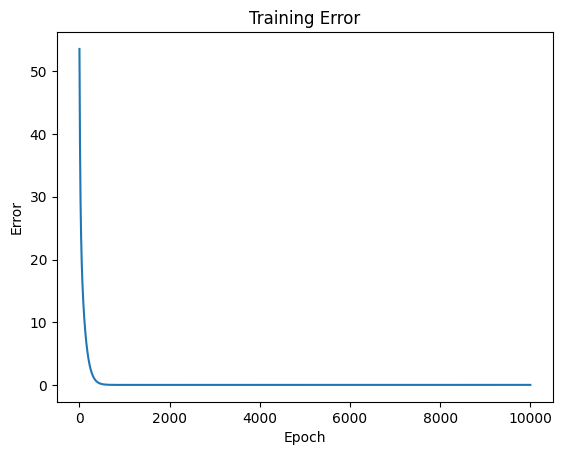

In [11]:
nn = NeuralNetwork(input_size=36, hidden_size=8, output_size=2)    
errors = nn.train(X, y, epochs=10000, learning_rate=0.1)

# Plot the errors
plt.plot(errors)
plt.title('Training Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

OK, the network is trained and the model error is low. Now let's check which features are most important in accordance to this model.

c:\Users\mdzho\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


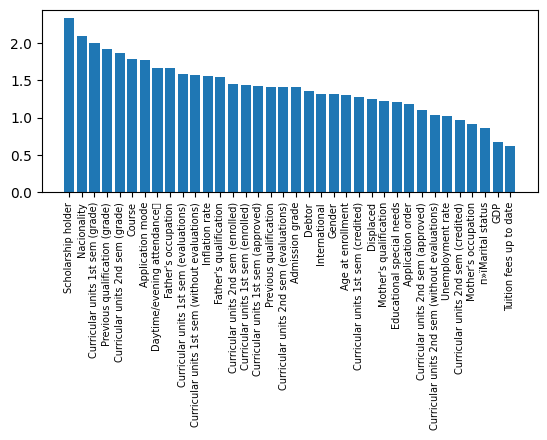

In [12]:
# Rank the features by their importance (weights of the hidden layer)
ranked_features = nn.rank_features()
feature_importance = [ranked_features[i][1] for i in range(len(ranked_features))]
feature_importance_names = [feature_names[ranked_features[i][0]] for i in range(len(ranked_features))]

# Plot the ranked features
plt.bar(feature_importance_names, feature_importance)
plt.xticks(rotation=90, size=7)
plt.subplots_adjust(bottom=0.5) # The labels are too long, so we need to adjust the plot
plt.show()

To be frank I have run above network training hundreds of times and I received big variations in the feature importance ranking. 

However, I noticed some features are almost always in the tail of the list:
* `Application mode`
* `Application order`
* `Inflation rate`
* `Unemployment rate`
* `Course`
* `Daytime/evening attendance`
* `International`
* `Tuition fees up to date`
* `Marital status`

So I discarded them from my next experiments.

Furthermore, there is probably a hidden relation (dependency) between some of the features:
* `Mother's/Father's occupations` are related to `Mother's/Father's qualifications`
* we have 12 features in probable relation between them (all the `Curricular units 1st/2nd sem`)

Maybe a **single feature from each such group** would be enough for training the model.

## Conclusion

#### Reconstruction accuracy
After a lot of testing with different versions of my Autoencoder model it turned out that for best overall reconstruction this subset of features delivers best results (e.g. **100% reconstruction accuracy**) :

1. `Curricular units 2nd sem (without evaluations)` - This column tracks the number of educational units that were left without grade at the end of 2nd semester. Seems like a reasonable candidate for dropout predictive model. NB: Adding another `Curricular units` column didn't help to improve the model accuracy, so I didn't include them.

2. `Father's qualification` - this feature is part of a similar group that represents the economic status of the student's family (the other features in this group are `Father's occupation`, `Mother's occupation` and `Mother's qualification`). Again, here we need only a single column from this group and the best results were achieved when I used `Father's qualification`.

3. `Scholarship holder` - student's GPA proxy (usually, students with high grades are not dropouts)

4. `Educational special needs` - I guess students with special needs are more prone to dropping out.

5. `Debtor` - Another proxy fot the socioeconomic status of the student's family. I am not sure exactly why, but this feature improves the model accuracy.

6. `Nacionality` - another feature I am not sure why it is so important for the model, but it turns out to have good effect on the accuracy too.


#### Anomaly detection
However, for anomaly detection the best configuration would be using **all the features**.